# Imports

In [2]:
import time
import numpy as np
import torch
from torchvision import transforms as T
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import ConcatDataset, DataLoader

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

from pathlib import Path

from tqdm.notebook import tqdm
from torch.utils.tensorboard import SummaryWriter

import sys
sys.path.append("..")

from data import pacs

from models import resnet_ms, custom_models


# Config

## Regarding Dataset

In [3]:
NUM_CLASSES = 7
CLASSES = ["dog", "elephant", "giraffe", "guitar", "horse", "house", "person"]
DOMAINS = ["art_painting", "cartoon", "photo", "sketch"]

## Hyperparameters

In [4]:
EPOCHS = 25
BATCH_SIZE = 32
LEARNING_RATE = 1e-3
REGULARIZATION = 1e-4
MOMENTUM = 0.9
MODEL = custom_models.resnet50_fc512_ms12_a0d1_fr1
USE_PRETRAINED = True
OPTIMIZER = optim.SGD
OPTIMIZER_KWARGS = {
    "lr": LEARNING_RATE,
    "weight_decay": REGULARIZATION,
    "momentum": MOMENTUM
}
SCHEDULER = optim.lr_scheduler.CosineAnnealingLR # optim.lr_scheduler.ReduceLROnPlateau
SCHEDULER_KWARGS = {"T_max": EPOCHS} # {"mode": "min", "patience": 5}
EARLY_STOPPING_PATIENCE = 5
EARLY_STOPPING_DELTA = 1e-5
AUGMENTATIONS = ()
NUM_SEEDS = 3

## Debug

In [5]:
verbose = False

## Image Normalization

In [6]:
# Values for pretrained ResNet
pretrained_image_transform = T.Compose([
    *AUGMENTATIONS,
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

## Device

In [7]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
if verbose:
    print(f"Device: {device}")

## Abstract model building, optimizer and scheduler

In [ ]:
build_model = lambda: MODEL(NUM_CLASSES, loss='softmax', pretrained=USE_PRETRAINED, verbose=verbose)
build_optimizer = lambda model: OPTIMIZER(model.parameters(), **OPTIMIZER_KWARGS)
build_scheduler = lambda optimizer: SCHEDULER(optimizer, **SCHEDULER_KWARGS)

# Set seed for reproducibility

In [9]:
# seed = 42
# torch.manual_seed(42)
# if device == torch.device("cuda"):
#     torch.cuda.manual_seed(seed)
#     torch.backends.cudnn.deterministic = True

# Training

In [10]:
writer = SummaryWriter()
%load_ext tensorboard
%tensorboard --logdir ./runs

Reusing TensorBoard on port 6006 (pid 25156), started 18 days, 7:18:22 ago. (Use '!kill 25156' to kill it.)

## Training Loop

In [11]:
class AverageMeter:
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.avg = 0
        self.sum = 0
        self.count = 0
    
    def update(self, val, n):
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [12]:
def accuracy(target, output):
    batch_size = target.shape[0]
    _, pred = torch.max(output, dim=-1)
    correct = pred.eq(target).sum()
    return correct.item() / batch_size

In [ ]:
def train(epoch: int,
          target_domain: str,
          data_loader: torch.utils.data.DataLoader,
          model: nn.Module,
          optimizer: optim.Optimizer
          ) -> tuple[float, float]:
    """train one epoch"""
    model.train()
    losses = AverageMeter()
    accs = AverageMeter()

    for i, (data, _domain, target) in enumerate(data_loader):
        # Print progress every 20 batches for debugging
        if verbose and i % 20 == 0 and i > 0:
            print(f"Batch {i+1}/{len(data_loader)}")

        step = (epoch - 1) * len(data_loader) + i + 1
        data = data.to(device)
        target = target.to(device)

        out = model(data)
        loss = F.cross_entropy(out, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = accuracy(target, out)
        losses.update(loss.item(), out.shape[0])
        accs.update(acc, out.shape[0])

        writer.add_scalar(f'Loss/Train/target={target_domain}', loss.item(), step)
        writer.add_scalar(f'Accuracy/Train/target={target_domain}', acc, step)

    return losses.avg, accs.avg

## Evaluation

In [14]:
def evaluate(data_loader: torch.utils.data.DataLoader, model: nn.Module, phase="val") -> tuple[float, float]:
    model.eval()

    losses = AverageMeter()
    accs = AverageMeter()

    with torch.no_grad():
        for data, _domain, target in data_loader:
            data = data.to(device)
            target = target.to(device)

            out = model(data)

            # The implementation returns only the feature vector rather than the classification logits.
            # To compare the labels, we therefore must apply the classification layer manually:
            out = model.classifier(out)

            loss = F.cross_entropy(out, target)
            acc = accuracy(target, out)

            losses.update(loss.item(), out.shape[0])
            accs.update(acc, out.shape[0])
    
    return losses.avg, accs.avg

## Training Loop

In [ ]:
all_results = {d: [] for d in DOMAINS}
all_results['avgs'] = []
all_results['worst'] = []

if verbose:
    print("Starting training...")

for seed in tqdm(range(NUM_SEEDS), desc="Seeds"):
    if seed > 0:
        writer = SummaryWriter()
    results = {}

    for target_domain in tqdm(DOMAINS, desc="Target Domain"):
        if verbose:
            print(f"Processing target domain: {target_domain}")

        model = build_model()
        model = model.to(device)

        optimizer = build_optimizer(model)
        scheduler = build_scheduler(optimizer)

        if not USE_PRETRAINED:
            if verbose:
                print(
                    f"Computing normalization stats excluding domain {target_domain}...")

            img_mean, img_std = pacs.get_normalization_stats(target_domain)

            if verbose:
                print(
                    f"Normalization values excluding domain {target_domain}:\n\tmean: {img_mean}\n\tstd: {img_std}")

            image_transform = T.Compose([
                *AUGMENTATIONS,
                T.Resize(256),
                T.CenterCrop(224),
                T.ToTensor(),
                T.Normalize(mean=img_mean, std=img_std)
            ])
        else:
            image_transform = pretrained_image_transform
            if verbose:
                print(f"Using model's pretrained normalization stats")

        if verbose:
            print(f"Loading data for target domain {target_domain}...")

        train_loader, test_loader, val_loader =\
            pacs.get_data_loaders(target_domain,
                                  train_batch_size=BATCH_SIZE,
                                  split="threefold",
                                  transform=image_transform,
                                  shuffle_test=True,
                                  drop_last=True)

        best_loss = float('inf')
        patience_counter = 0

        feature_tracker = None
        epoch_results = {"train_loss": [],
                         "train_acc": [], "val_loss": [], "val_acc": []}

        for epoch in tqdm(range(1, EPOCHS + 1), desc=f"Epoch ({target_domain})"):
            if verbose:
                print(f"\nEpoch {epoch}/{EPOCHS} for {target_domain}. Training...")

            start_time = time.time()
            train_loss, train_acc = train(
                epoch, target_domain, train_loader, model, optimizer)
            train_time = time.time() - start_time
            if verbose:
                print(
                    f"Training done in {train_time:.2f}s - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")

            val_loss, val_acc = evaluate(val_loader, model)

            epoch_results["train_loss"].append(train_loss)
            epoch_results["train_acc"].append(train_acc)
            epoch_results["val_loss"].append(val_loss)
            epoch_results["val_acc"].append(val_acc)

            writer.add_scalar(f"Loss/Val/target={target_domain}", val_loss, epoch)
            writer.add_scalar(f"Accuracy/Val/target={target_domain}", val_acc, epoch)

            scheduler.step()  # scheduler.step(val_loss) if scheduler needs criterium

            if best_loss - val_loss < EARLY_STOPPING_DELTA and (patience_counter := patience_counter+1) > EARLY_STOPPING_PATIENCE:
                if verbose:
                    print(
                        f"Early stopping triggered at epoch {epoch+1} (patience: {patience_counter})")
                break

            if val_loss < best_loss:
                best_loss = val_loss
                if verbose:
                    print(f"Saving best model (loss: {best_loss:.4f})")
                torch.save(model.state_dict(), f"../checkpoints/pacs/best_{target_domain}.pt")

        if verbose:
            print(f"\nTraining summary for target domain {target_domain}:")
            print(f"  Best validation accuracy: {max(epoch_results['val_acc']):.4f} (epoch {np.argmax(epoch_results['val_acc'])+1})")
            print(f"  Final validation accuracy: {epoch_results['val_acc'][-1]:.4f}")
            print(f"  Best validation loss: {min(epoch_results['val_loss']):.4f} (epoch {np.argmin(epoch_results['val_loss'])+1})")
            print(f"  Final validation loss: {epoch_results['val_loss'][-1]:.4f}")

        if verbose:
            print("\nLoading best model for testing...")
        model.load_state_dict(torch.load(
            f"../checkpoints/pacs/best_{target_domain}.pt"))
        _, acc = evaluate(test_loader, model, phase="test")
        if verbose:
            print(f"Test accuracy for target domain {target_domain}: {acc:.4f}\n")

        results[target_domain] = acc

    avg_acc = np.mean([*results.values()])
    worst_case_acc = np.min([*results.values()])

    for d in DOMAINS:
        all_results[d].append(results[d])
    all_results['avgs'].append(avg_acc)
    all_results['worst'].append(worst_case_acc)

Seeds:   0%|          | 0/3 [00:00<?, ?it/s]

Target Domain:   0%|          | 0/4 [00:00<?, ?it/s]

Insert MixStyle after the following layers: ['layer1', 'layer2']
Freezing the following layers ['layer1']


Epoch (art_painting):   0%|          | 0/25 [00:00<?, ?it/s]

Insert MixStyle after the following layers: ['layer1', 'layer2']
Freezing the following layers ['layer1']


Epoch (cartoon):   0%|          | 0/25 [00:00<?, ?it/s]

Insert MixStyle after the following layers: ['layer1', 'layer2']
Freezing the following layers ['layer1']


Epoch (photo):   0%|          | 0/25 [00:00<?, ?it/s]

Insert MixStyle after the following layers: ['layer1', 'layer2']
Freezing the following layers ['layer1']


Epoch (sketch):   0%|          | 0/25 [00:00<?, ?it/s]

Target Domain:   0%|          | 0/4 [00:00<?, ?it/s]

Insert MixStyle after the following layers: ['layer1', 'layer2']
Freezing the following layers ['layer1']


Epoch (art_painting):   0%|          | 0/25 [00:00<?, ?it/s]

Insert MixStyle after the following layers: ['layer1', 'layer2']
Freezing the following layers ['layer1']


Epoch (cartoon):   0%|          | 0/25 [00:00<?, ?it/s]

Insert MixStyle after the following layers: ['layer1', 'layer2']
Freezing the following layers ['layer1']


Epoch (photo):   0%|          | 0/25 [00:00<?, ?it/s]

Insert MixStyle after the following layers: ['layer1', 'layer2']
Freezing the following layers ['layer1']


Epoch (sketch):   0%|          | 0/25 [00:00<?, ?it/s]

Target Domain:   0%|          | 0/4 [00:00<?, ?it/s]

Insert MixStyle after the following layers: ['layer1', 'layer2']
Freezing the following layers ['layer1']


Epoch (art_painting):   0%|          | 0/25 [00:00<?, ?it/s]

Insert MixStyle after the following layers: ['layer1', 'layer2']
Freezing the following layers ['layer1']


Epoch (cartoon):   0%|          | 0/25 [00:00<?, ?it/s]

Insert MixStyle after the following layers: ['layer1', 'layer2']
Freezing the following layers ['layer1']


Epoch (photo):   0%|          | 0/25 [00:00<?, ?it/s]

Insert MixStyle after the following layers: ['layer1', 'layer2']
Freezing the following layers ['layer1']


Epoch (sketch):   0%|          | 0/25 [00:00<?, ?it/s]

## Training Results (Test time)

In [16]:
print("Average Accuracy:\n" +
      "{}".format("".join(f"\t{d}: {np.mean(all_results[d]):.4f}, std: {np.std(all_results[d]):.4f}\n" for d in DOMAINS)) +
      f"\ttotal: {np.mean(all_results['avgs']):.4f}, std: {np.std(all_results['avgs']):.4f}\n"
      "Worst-case Accuracy:\n" +
      "{}".format("".join(f"\t{d}: {np.min(all_results[d]):.4f}\n" for d in DOMAINS)) +
      f"\ttotal: {np.mean(all_results['worst']):.4f}, std: {np.std(all_results['worst']):.4f}"
      )

Average Accuracy:
	art_painting: 0.7308, std: 0.0452
	cartoon: 0.7469, std: 0.0026
	photo: 0.9732, std: 0.0015
	sketch: 0.7054, std: 0.0295
	total: 0.7890, std: 0.0170
Worst-case Accuracy:
	art_painting: 0.6685
	cartoon: 0.7432
	photo: 0.9712
	sketch: 0.6768
	total: 0.7026, std: 0.0323


## Domain Vis

In [17]:
#Parameters for Vis
# Hyperparams for annotation
perplexity = 30 
pca_dims   = 50
tsne_iters = 2000
seed = 42 # Note this needs to be dynamically for 3 seed run

In [18]:
val_sets = []
for d in DOMAINS:
    _, vl = pacs.get_data_loaders(
        d,
        train_batch_size=BATCH_SIZE,
        transform=pretrained_image_transform,
        shuffle_test=False,
        drop_last=False
    )
    val_sets.append(vl.dataset)

combined_val = ConcatDataset(val_sets)
combined_loader = DataLoader(
    combined_val,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=10
)
print(f"Combined loader size: {len(combined_val)} samples")

Combined loader size: 9991 samples


In [19]:
# — extract penultimate features & domain labels —
# Right before the classification layer.
# Extract features per domain into flat numpy arrays

all_feats, all_doms = [], []
max_samples = 9991

for idx, dom in enumerate(DOMAINS):
    _, val_loader = pacs.get_data_loaders(
        dom,
        train_batch_size=BATCH_SIZE,
        transform=pretrained_image_transform,
        shuffle_test=False,
        drop_last=False
    )
    feats_dom, count = [], 0
    with torch.no_grad():
        for imgs, _domain_idx, _ in val_loader:
            imgs = imgs.to(device)
            v = model(imgs)  # pooled feature vector [B, D]
            feats_dom.append(v.cpu())
            count += v.size(0)
            if count >= max_samples:
                break
    feats_dom = torch.cat(feats_dom)[:max_samples].numpy()
    dom_idxs = np.full(feats_dom.shape[0], idx)
    all_feats.append(feats_dom)
    all_doms.append(dom_idxs)

feats = np.concatenate(all_feats, axis=0)
doms  = np.concatenate(all_doms, axis=0)
print(f"Extracted {feats.shape[0]} features across {len(DOMAINS)} domains")

# normalize
feats = (feats - feats.mean(0)) / feats.std(0)

# PCA to 50 dims (x components => x top eigenvectors)
feats_pca = PCA(n_components=50, random_state=42).fit_transform(feats)

# t-SNE to 2D
# Hint on TSNE: n_components => number of dimensions of the embedding. Increase perplextity to include more points into the nearest neighbor calculation, small perplexity visualizes better smaller clusters (not advisible for us imo). max_iter => number of iterations. random_state => random seed.


tsne = TSNE(n_components=2, perplexity=30, max_iter=2000, random_state=42)
emb  = tsne.fit_transform(feats_pca)
print("t-SNE embedding complete")

Extracted 9991 features across 4 domains
t-SNE embedding complete


Silhouette Score: 0.1046
Plot saved as: tsne_pacs_ep25_bs32_lr1e-03_reg1e-04_mom0d9_resnet50_fc512_ms12_a0d1_fr1_pretrainedTrue_SGD_CosineAnnealingLR_patience5_delta1e-05_seeds3_pca50_perp30_iters2000_seed42_silhouette0d1046.png


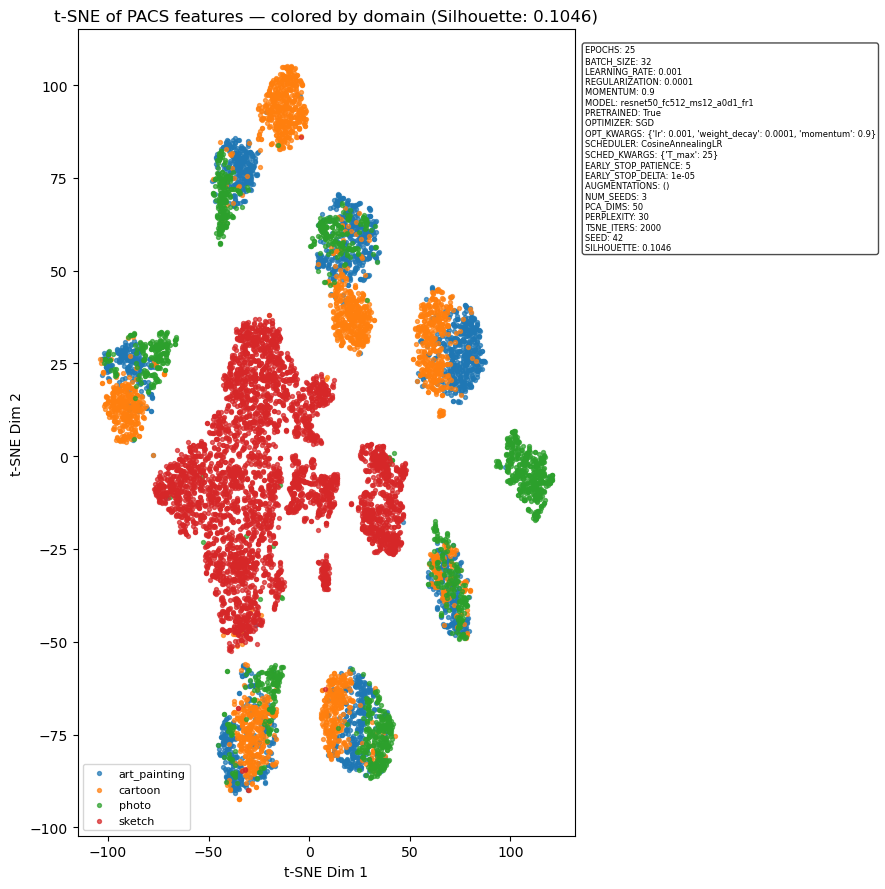

In [ ]:
# Compute silhouette score
# The silhouette score is a measure of how similar a point is to its own cluster compared to other clusters.
# For MixStyle we expect a lower silhouette score, for DOMAIN, when comparing to a normal ResNEt
silhouette_avg = silhouette_score(emb, doms)
print(f"Silhouette Score: {silhouette_avg:.4f}")

# 
param_text = (
    f"EPOCHS: {EPOCHS}\n"
    f"BATCH_SIZE: {BATCH_SIZE}\n"
    f"LEARNING_RATE: {LEARNING_RATE}\n"
    f"REGULARIZATION: {REGULARIZATION}\n"
    f"MOMENTUM: {MOMENTUM}\n"
    f"MODEL: {MODEL.__name__}\n"
    f"PRETRAINED: {USE_PRETRAINED}\n"
    f"OPTIMIZER: {OPTIMIZER.__name__}\n"
    f"OPT_KWARGS: {OPTIMIZER_KWARGS}\n"
    f"SCHEDULER: {SCHEDULER.__name__}\n"
    f"SCHED_KWARGS: {SCHEDULER_KWARGS}\n"
    f"EARLY_STOP_PATIENCE: {EARLY_STOPPING_PATIENCE}\n"
    f"EARLY_STOP_DELTA: {EARLY_STOPPING_DELTA}\n"
    f"AUGMENTATIONS: {AUGMENTATIONS}\n"
    f"NUM_SEEDS: {NUM_SEEDS}\n"
    f"PCA_DIMS: {pca_dims}\n"
    f"PERPLEXITY: {perplexity}\n"
    f"TSNE_ITERS: {tsne_iters}\n"
    f"SEED: {seed}\n"
    f"SILHOUETTE: {silhouette_avg:.4f}"
)

plt.figure(figsize=(9,9))
for idx, dom in enumerate(DOMAINS):
    mask = (doms == idx)
    plt.scatter(emb[mask,0], emb[mask,1],
                label=dom, s=8, alpha=0.7)

# Place the annotation box
plt.gca().text(
    1.02, 0.98, param_text,
    transform=plt.gca().transAxes,
    fontsize=6, va='top', ha='left',
    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7)
)

plt.legend(loc='lower left', fontsize=8)
plt.title(f"t-SNE of PACS features — colored by domain (Silhouette: {silhouette_avg:.4f})")
plt.xlabel("t-SNE Dim 1"); plt.ylabel("t-SNE Dim 2")
plt.tight_layout()

# Create comprehensive filename with all parameters
filename = (
    f"tsne_pacs_3f_"
    f"ep{EPOCHS}_"
    f"bs{BATCH_SIZE}_"
    f"lr{LEARNING_RATE:.0e}_"
    f"reg{REGULARIZATION:.0e}_"
    f"mom{MOMENTUM}_"
    f"{MODEL.__name__}_"
    f"pretrained{USE_PRETRAINED}_"
    f"{OPTIMIZER.__name__}_"
    f"{SCHEDULER.__name__.split('.')[-1]}_"
    f"patience{EARLY_STOPPING_PATIENCE}_"
    f"delta{EARLY_STOPPING_DELTA:.0e}_"
    f"seeds{NUM_SEEDS}_"
    f"pca{pca_dims}_"
    f"perp{perplexity}_"
    f"iters{tsne_iters}_"
    f"seed{seed}_"
    f"silhouette{silhouette_avg:.4f}"
).replace(".", "d") + ".png"

output_path = Path("../model_comparison/pacs/")
output_path.mkdir(parents=True, exist_ok=True)

# Save the plot
plt.savefig((output_path / filename).resolve(), dpi=300, bbox_inches='tight')
print(f"Plot saved as: {filename}")

plt.show()


# For MixStyle we expect when visualizing the domain separation, that the domains should be closer together, showing that the model became domain agnostic.